In [15]:
pip install openpyxl


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd
file_path = "D:/flight_price_predictor/Data_Train.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')
print(df.shape)
df.head()



(10683, 11)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [18]:
df['Journey_day'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.day
df['Journey_month'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.month
df.drop(['Date_of_Journey'], axis=1, inplace=True)


In [21]:
print(df.columns)


Index(['Airline', 'Source', 'Destination', 'Route', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_minute', 'Arrival_hour', 'Arrival_minute'],
      dtype='object')


In [22]:

df['Duration'] = df['Duration'].apply(
    lambda x: x if 'h' in x and 'm' in x else 
              (x + ' 0m' if 'h' in x else '0h ' + x)
)
df['Duration_hours'] = df['Duration'].apply(lambda x: int(x.split('h')[0].strip()))
df['Duration_minutes'] = df['Duration'].apply(lambda x: int(x.split('h')[1].replace('m','').strip()))

df.drop('Duration', axis=1, inplace=True)


In [27]:
df['Total_Stops'] = df['Total_Stops'].replace({
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
})
print(df['Total_Stops'].isnull().sum())
df['Total_Stops'] = df['Total_Stops'].fillna(1)
df['Total_Stops'] = df['Total_Stops'].astype(int)


0


In [30]:
df.drop(['Route', 'Additional_Info'], axis=1, inplace=True)

In [31]:
df = pd.get_dummies(df, columns=['Airline', 'Source', 'Destination'], drop_first=True)

In [32]:
print(df.shape)
df.head()

(10683, 30)


,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_minutes,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,...,False,False,False,False,False,False,False,False,False,True
1,2,7662,1,5,5,50,13,15,7,25,...,False,False,False,True,False,False,False,False,False,False
2,2,13882,9,6,9,25,4,25,19,0,...,False,False,True,False,False,True,False,False,False,False
3,1,6218,12,5,18,5,23,30,5,25,...,False,False,False,True,False,False,False,False,False,False
4,1,13302,1,3,16,50,21,35,4,45,...,False,False,False,False,False,False,False,False,False,True


In [33]:
X = df.drop('Price', axis=1)   
y = df['Price']                


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2_score(y_test, y_pred))



MAE: 1194.8145677998887
MSE: 4519192.083135822
RMSE: 2125.8391479921106
R2 Score: 0.7864676180614576


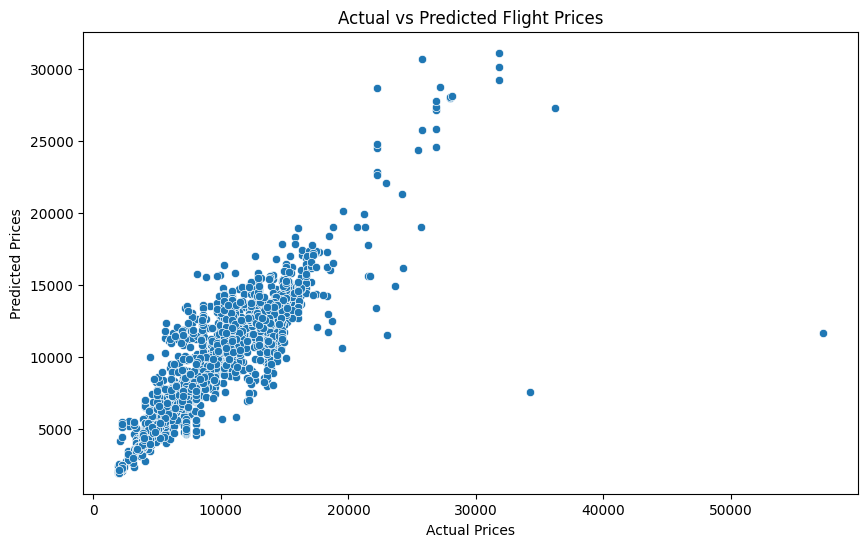

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Flight Prices")
plt.show()


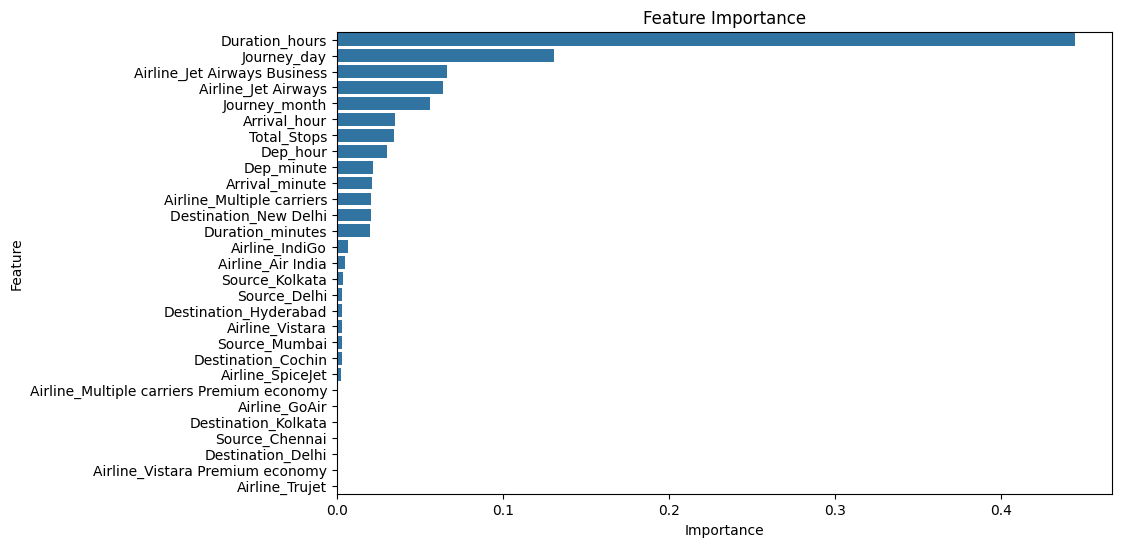

In [39]:
importances = model.feature_importances_
feature_names = X.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importance")
plt.show()


In [40]:
import joblib

joblib.dump(model, 'flight_price_model.pkl')


['flight_price_model.pkl']

In [41]:
def predict_price(input_data):
    prediction = model.predict(input_data)
    return prediction


In [42]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import joblib
joblib.dump(X.columns.tolist(), 'model_features.pkl')


['model_features.pkl']

In [44]:
import joblib
joblib.dump(X.columns.tolist(), 'model_features.pkl')


['model_features.pkl']